In [1]:
!nvidia-smi

Tue Mar 28 13:18:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.36       Driver Version: 512.36       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3    20W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.5.0

numpy       : 1.22.1
pandas      : 1.5.0
torch       : 1.12.1+cu113
transformers: 4.24.0



In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan
from transformers import BertTokenizer,BertModel

file_path = "C:/Users/is_li/Desktop/paper/github/stock on MLOps/uploads"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = file_path +'/model/NLP_Astock/ROBERT_4_model.bin'


# sns.countplot(df.label_norm)
# plt.xlabel('review score');
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

import ast

df_train = pd.read_csv(file_path + '/data/Astock_data/train.csv',sep='\t')
df_val = pd.read_csv(file_path + '/data/Astock_data/val.csv',sep='\t')
df_test = pd.read_csv(file_path + '/data/Astock_data/test.csv',sep='\t')
df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')

df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)[:1000]
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)[:200]
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)[:200]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)[:200]

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

import Astock
for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(Astock.string_to_tuples_list)
  df_val[col] = df_val[col].apply(Astock.string_to_tuples_list)
  df_test[col] = df_test[col].apply(Astock.string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)


df_train = Astock.mask(df_train)
df_test = Astock.mask(df_test)
df_val = Astock.mask(df_val)
df_ood = Astock.mask(df_ood)

max_len = 300
class_names = ['negative','neutral', 'positive']
from Astock import create_data_loader

# df_train.sample(n=4000).to_csv('/content/drive/MyDrive/data/df_train_srl.csv',sep='\t',index=None)
# df_test.sample(n=500).to_csv('/content/drive/MyDrive/data/df_test_srl.csv',sep='\t',index=None)
# df_val.sample(n=500).to_csv('/content/drive/MyDrive/data/df_val_srl.csv',sep='\t',index=None)

BATCH_SIZE = 2

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

from Astock import SentimentClassifier
model = SentimentClassifier(3)
model = model.to(device)
data = next(iter(train_data_loader))
data.keys()
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

output = model(input_ids, attention_mask)
# output.attentions[0][0].shape
# len(output.attentions)
# output.attentions[0][:,:,:,:]
# torch.sum(output.attentions[0][:,:,:,:],1)[:,1,:]
# output.attentions[0]
# F.softmax(output[0], dim=1)

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)

history = defaultdict(list)
best_accuracy = 0

Some weights of the model checkpoint at C:/Users/is_li/Desktop/paper/github/stock on MLOps/uploads/model/NLP_Astock/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at C:/Users/is_li/Desktop/paper/g

torch.Size([2, 300])
torch.Size([2, 300])


c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
df_train = pd.read_csv(file_path + '/data/Astock_data/train.csv',sep='\t')
df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)[:1000]
df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)

In [11]:
df = df_train[:10].to_csv("df_examplr.csv")

In [1]:
# EPOCHS = 5

# %%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = Astock.train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = Astock.eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBERT.bin')
    best_accuracy = val_acc

len(history["train_acc"])

plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

class_names={'negative','neutral','positive'}

# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Pretrained_RoBERT.bin'))
model = model.to(device)

len(df_test)

test_acc, _ = Astock.eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


KeyboardInterrupt: 

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from Astock import train_epoch, eval_model, create_data_loader, SentimentClassifier, mask, string_to_tuples_list
import ast
import matplotlib.pyplot as plt
from torch import nn
from collections import defaultdict

def load_data(file_path):
    df_train = pd.read_csv(file_path + '/data/Astock_data/train.csv',sep='\t')
    df_val = pd.read_csv(file_path + '/data/Astock_data/val.csv',sep='\t')
    df_test = pd.read_csv(file_path + '/data/Astock_data/test.csv',sep='\t')
    df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')
    return df_train, df_val, df_test, df_ood

def preprocess_data(df):
    df = df.drop(df.loc[df.verbA0A1.isna()].index)
    df = df.drop(df.loc[df.verbA0A1=='[]'].index)
    for col in ['verb','A0','A1']:
        df[col] = df[col].apply(string_to_tuples_list)
    for col in ['stock_factors','verbA0A1']:
        df[col] = df[col].apply(ast.literal_eval)
    df = mask(df)
    return df

def train_and_evaluate(df_train, df_val, df_test, tokenizer, device, model_path):
    train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

    model = SentimentClassifier(len(class_names))
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )
        print(f'Val   loss {val_loss} accuracy {val_acc}')


        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), model_path)
            best_accuracy = val_acc

    test_acc, _ = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )

    print(f'Test accuracy {test_acc.item()}')

    return history, model

import yaml

if __name__ == '__main__':
    with open("C:/Users/is_li/Desktop/paper/github/stock on MLOps/uploads/Astock_config.yaml", 'r') as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    file_path = config['file_path']
    PRE_TRAINED_MODEL_NAME = config['PRE_TRAINED_MODEL_NAME']
    model_path = config['model_path']
    device = torch.device(config['device'])
    max_len = config['max_len']
    BATCH_SIZE = config['BATCH_SIZE']
    EPOCHS = config['EPOCHS']
    class_names = config['class_names']
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

    df_train, df_val, df_test, df_ood = load_data(file_path)
    df_train = preprocess_data(df_train)
    df_val = preprocess_data(df_val)
    df_test = preprocess_data(df_test)
    df_ood = preprocess_data(df_ood)

    model = train_and_evaluate(df_train, df_val, df_test, tokenizer, device, model_path)

    # Plot training history
    plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
    plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()






Some weights of the model checkpoint at C:/Users/is_li/Desktop/paper/github/stock on MLOps/uploads/model/NLP_Astock/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at C:/Users/is_li/Desktop/paper/g

Epoch 1/10
----------
Train loss 0.9951481847905919 accuracy 0.5141768937790944
Val   loss 0.9766376299004754 accuracy 0.5612728503723764
Epoch 2/10
----------


将上述代码中的参数以yaml文件配置，展示修改部分的代码，不展示重复部分的代码，并将yaml文件展示

In [4]:
# text=df_test.loc[df_test.text_a.apply(len)<100].sample(n=1).text_a.values[0]

# text_final = ''
# for i in tokenizer.tokenize(text):
#     tem = ' '+i
#     text_final+=tem

# text_final = text_final[1:]



# #Credits to Lin Zhouhan(@hantek) for the complete visualization code
# import random, os, numpy, scipy
# from codecs import open
# def createHTML(texts, weights, fileName):
#     """
#     Creates a html file with text heat.
# weights: attention weights for visualizing
# texts: text on which attention weights are to be visualized
#     """
#     fileName = "./visualization/"+fileName
#     fOut = open(fileName, "w", encoding="utf-8")
#     part1 = """
#     <html lang="zh-Hans">
#     <head>
#     <meta http-equiv="content-type" content="text/html; charset=utf-8">
#     <style>
#     body {
#     font-family: Sans-Serif;
#     }
#     </style>
#     </head>
#     <body>
#     <h3>
#     Heatmaps
#     </h3>
#     </body>
#     <script>
#     """
#     part2 = """
#     var color = "255,0,0";
#     var ngram_length = 3;
#     var half_ngram = 1;
#     for (var k=0; k < any_text.length; k++) {
#     var tokens = any_text[k].split(" ");
#     var intensity = new Array(tokens.length);
#     var max_intensity = Number.MIN_SAFE_INTEGER;
#     var min_intensity = Number.MAX_SAFE_INTEGER;
#     for (var i = 0; i < intensity.length; i++) {
#     intensity[i] = 0.0;
#     for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
#     if (i+j < intensity.length && i+j > -1) {
#     intensity[i] += trigram_weights[k][i + j];
#     }
#     }
#     if (i == 0 || i == intensity.length-1) {
#     intensity[i] /= 2.0;
#     } else {
#     intensity[i] /= 3.0;
#     }
#     if (intensity[i] > max_intensity) {
#     max_intensity = intensity[i];
#     }
#     if (intensity[i] < min_intensity) {
#     min_intensity = intensity[i];
#     }
#     }
#     var denominator = max_intensity - min_intensity;
#     for (var i = 0; i < intensity.length; i++) {
#     intensity[i] = (intensity[i] - min_intensity) / denominator;
#     }
#     if (k%2 == 0) {
#     var heat_text = "<p><br><b>Example:</b><br>";
#     } else {
#     var heat_text = "<b>Example:</b><br>";
#     }
#     var space = " ";
#     for (var i = 0; i < tokens.length; i++) {
#     heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>"  + tokens[i] + "</span>";
#     if (space == "") {
#     space = " ";
#     }
#     }
#     //heat_text += "<p>";
#     document.body.innerHTML += heat_text;
#     }
#     </script>
#     </html>"""
#     putQuote = lambda x: "\"%s\""%x
#     textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
#     weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
# #     print(part1)
# #     print(textsString)
# #     print(part2)
# #     print(weightsString)
#     fOut.write(part1)
#     fOut.write(textsString)
#     fOut.write(weightsString)
#     fOut.write(part2)
#     fOut.close()
  
#     return
# # ===================================================
# # 2. add text and get weight
# # ===================================================
# text1 = text_final
# tok = tokenizer.tokenize(text1)
# # text2 = 'NEWS'
# # p_pos = len(tok1)
# # tok2 = tokenizer.tokenize(text2)
# # tok = tok1+tok2


# ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')

# with torch.no_grad():
#     output = model.bert(ids)
# attentions = torch.cat(output[2]).to('cpu')

# # =================================================
# # 3. creat html attention heat map
# # =================================================
# createHTML([text1],[attentions[11,3,0,1:-2].numpy().tolist()],'Pretrained_RoBERT.html')


              precision    recall  f1-score   support

     neutral     0.6182    0.5075    0.5574        67
    negative     0.6232    0.5890    0.6056        73
    positive     0.5526    0.7000    0.6176        60

    accuracy                         0.5950       200
   macro avg     0.5980    0.5988    0.5936       200
weighted avg     0.6003    0.5950    0.5931       200



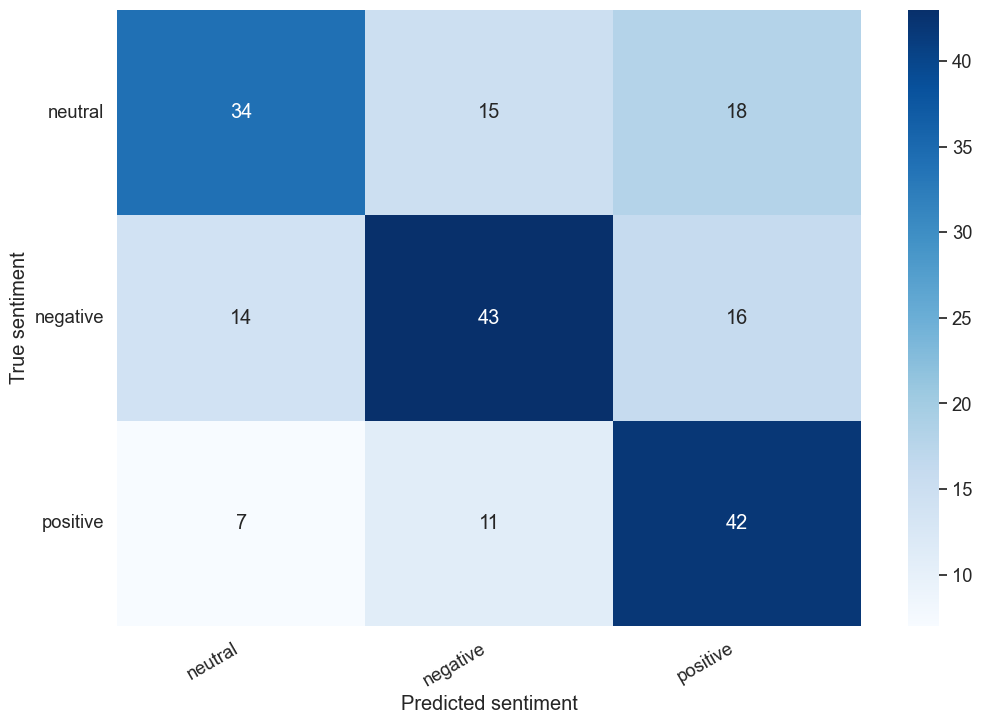

In [5]:
y_review_texts, y_pred, y_pred_probs, y_test = Astock.get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits = 4))


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

     neutral     0.5741    0.5082    0.5391        61
    negative     0.6458    0.4697    0.5439        66
    positive     0.5204    0.6986    0.5965        73

    accuracy                         0.5650       200
   macro avg     0.5801    0.5588    0.5598       200
weighted avg     0.5782    0.5650    0.5616       200



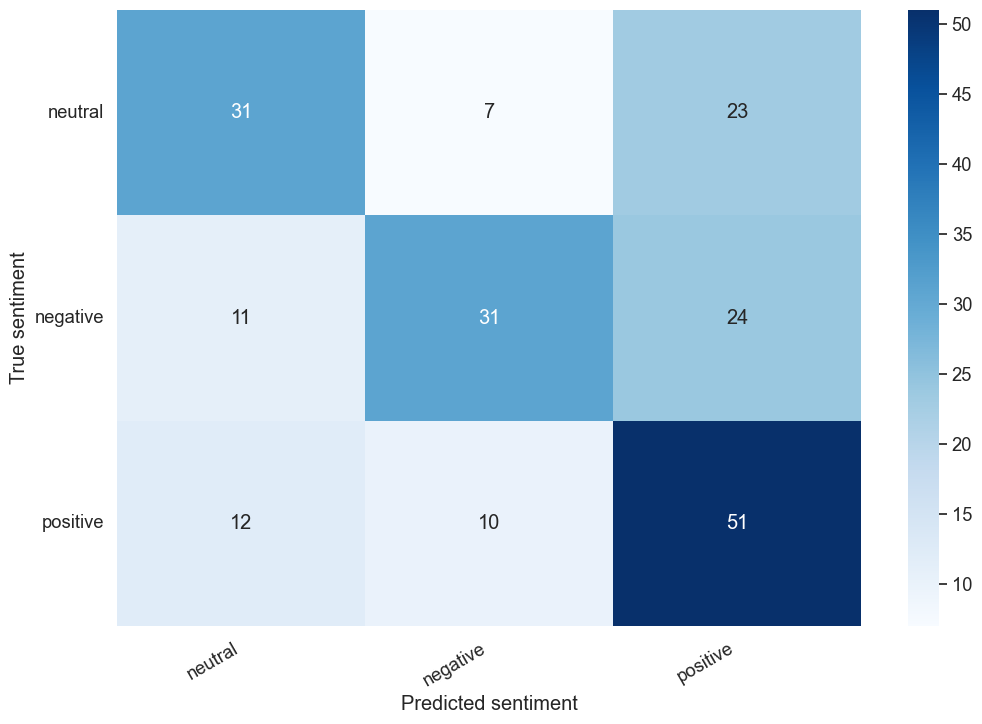

In [6]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

     neutral     0.5557    0.5239    0.5393       943
    negative     0.4745    0.4491    0.4615       953
    positive     0.5638    0.6083    0.5852      1330

    accuracy                         0.5366      3226
   macro avg     0.5313    0.5271    0.5286      3226
weighted avg     0.5350    0.5366    0.5352      3226



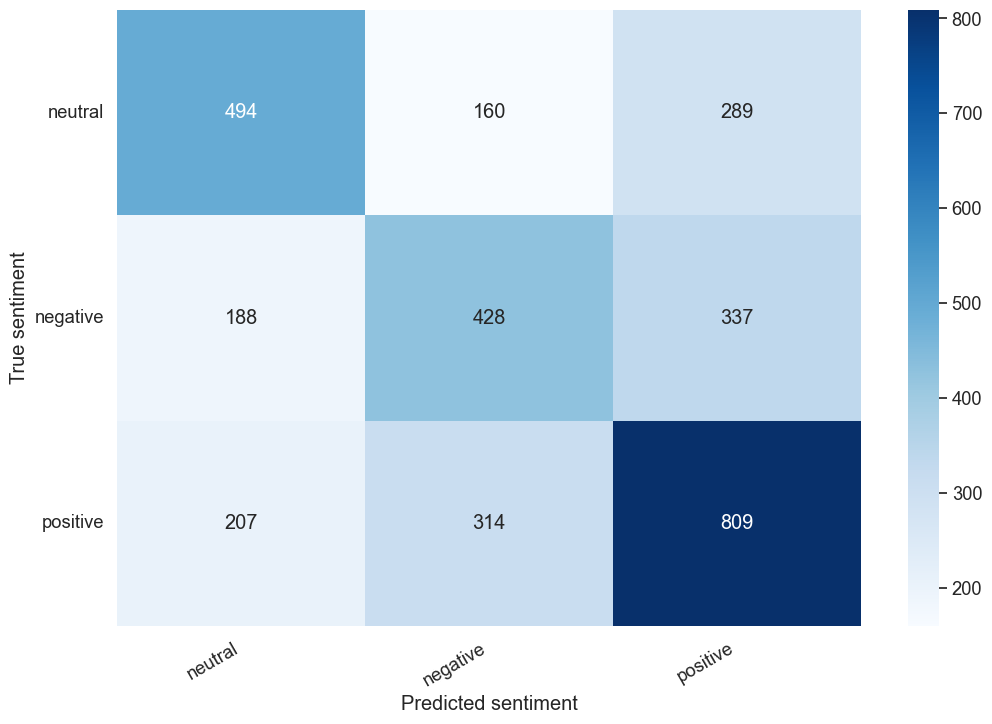

              precision    recall  f1-score   support

     neutral     0.5872    0.5730    0.5800       623
    negative     0.5710    0.4970    0.5314       825
    positive     0.5088    0.5871    0.5451       792

    accuracy                         0.5500      2240
   macro avg     0.5557    0.5524    0.5522      2240
weighted avg     0.5535    0.5500    0.5498      2240



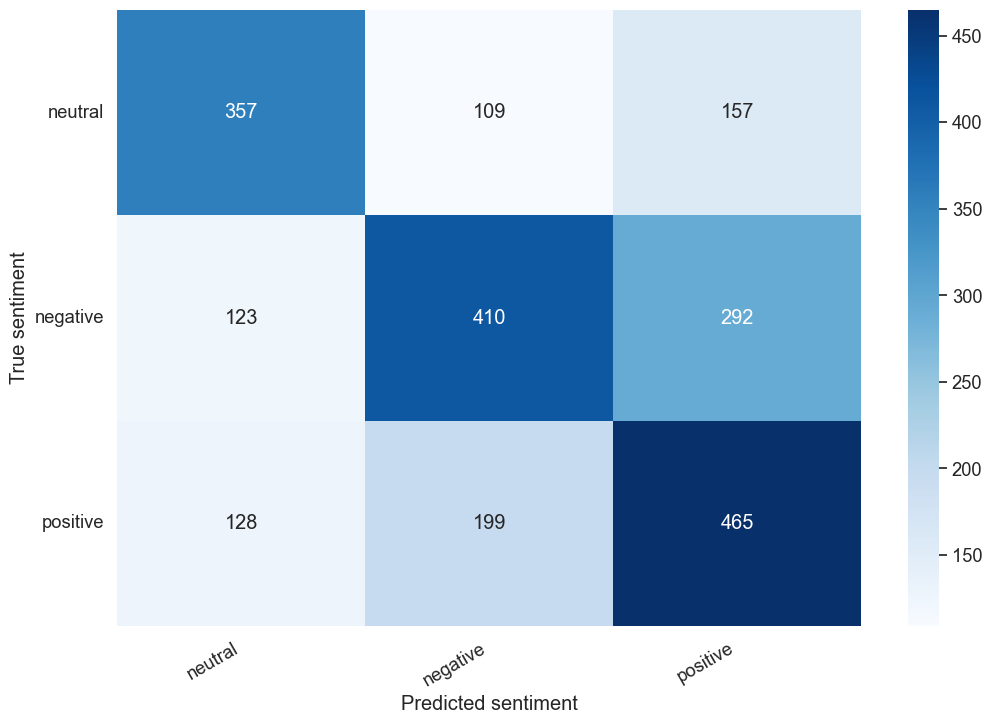

              precision    recall  f1-score   support

     neutral     0.6142    0.5160    0.5608      1157
    negative     0.4803    0.4996    0.4897      1169
    positive     0.5065    0.5705    0.5366      1092

    accuracy                         0.5278      3418
   macro avg     0.5337    0.5287    0.5291      3418
weighted avg     0.5340    0.5278    0.5288      3418



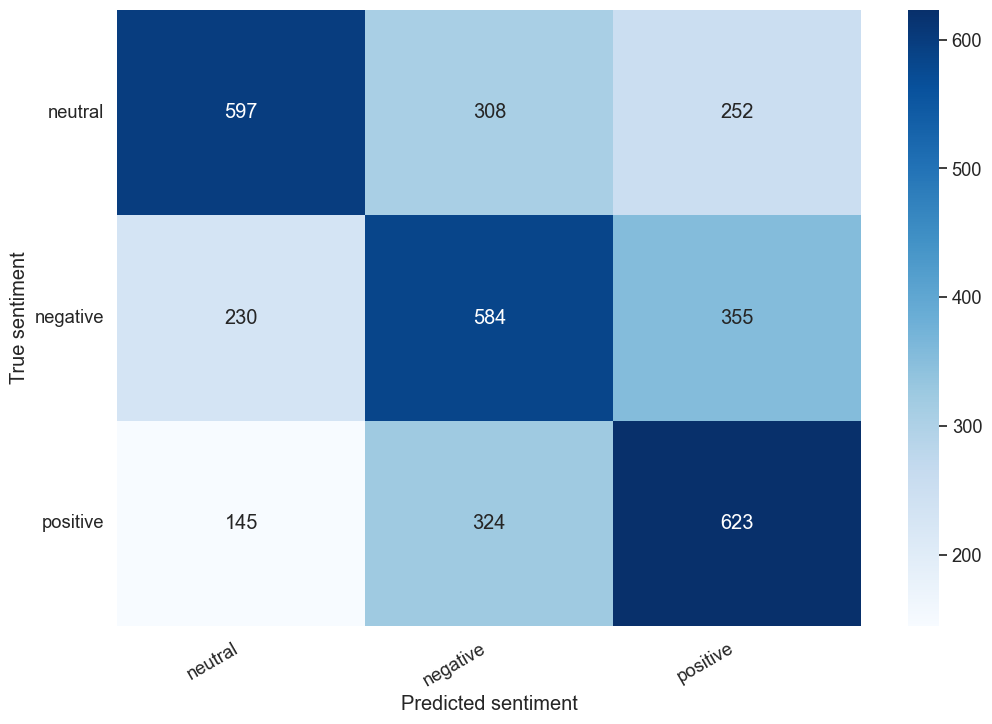

              precision    recall  f1-score   support

     neutral     0.5853    0.4332    0.4979       404
    negative     0.4869    0.4989    0.4928       447
    positive     0.4526    0.5643    0.5023       381

    accuracy                         0.4976      1232
   macro avg     0.5083    0.4988    0.4977      1232
weighted avg     0.5086    0.4976    0.4974      1232



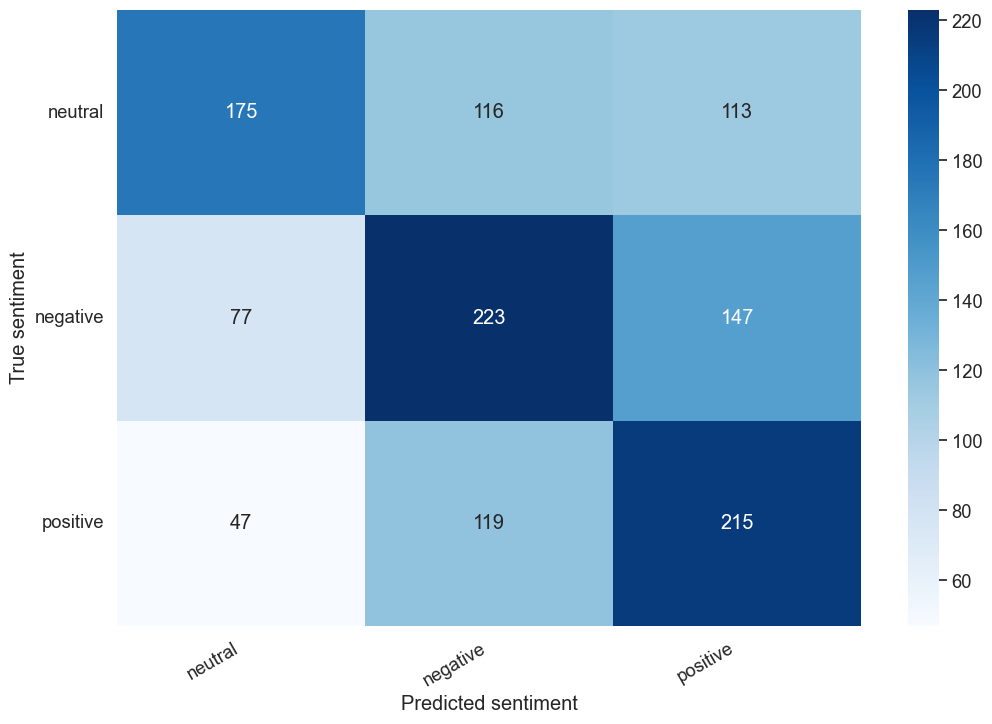

In [7]:
df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = Astock.mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = Astock.mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = Astock.mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv(file_path + '/data/Astock_data/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = Astock.mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)
plt.show()

In [ ]:
def evaluate_ood(file_path, start_date, end_date, tokenizer, model, max_len, BATCH_SIZE, class_names):
    df_ood = pd.read_csv(os.path.join(file_path, 'data/Astock_data/ood.csv'), sep='\t')
    df_ood = df_ood.loc[(df_ood.DATE >= start_date) & (df_ood.DATE <= end_date)]
    df_ood = df_ood.sort_values(by='DATE')
    df_ood = df_ood.reset_index(drop=True)
    df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
    df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1 == '[]'].index)
    for col in ['verb', 'A0', 'A1']:
        df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

    for col in ['stock_factors', 'verbA0A1']:
        df_ood[col] = df_ood[col].apply(ast.literal_eval)
    df_ood = Astock.mask(df_ood)
    df_ood = df_ood.reset_index(drop=True)
    ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

    y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
        model,
        ood_data_loader
    )

    print(classification_report(y_ood, y_ood_pred, target_names=class_names, digits=4))

    ood_cm = confusion_matrix(y_ood, y_ood_pred)
    df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
    Astock.show_confusion_matrix(df_ood_cm)
    plt.show()


    


c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral     0.0000    0.0000    0.0000         0
    negative     1.0000    0.3549    0.5238     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3549     16798
   macro avg     0.3333    0.1183    0.1746     16798
weighted avg     1.0000    0.3549    0.5238     16798



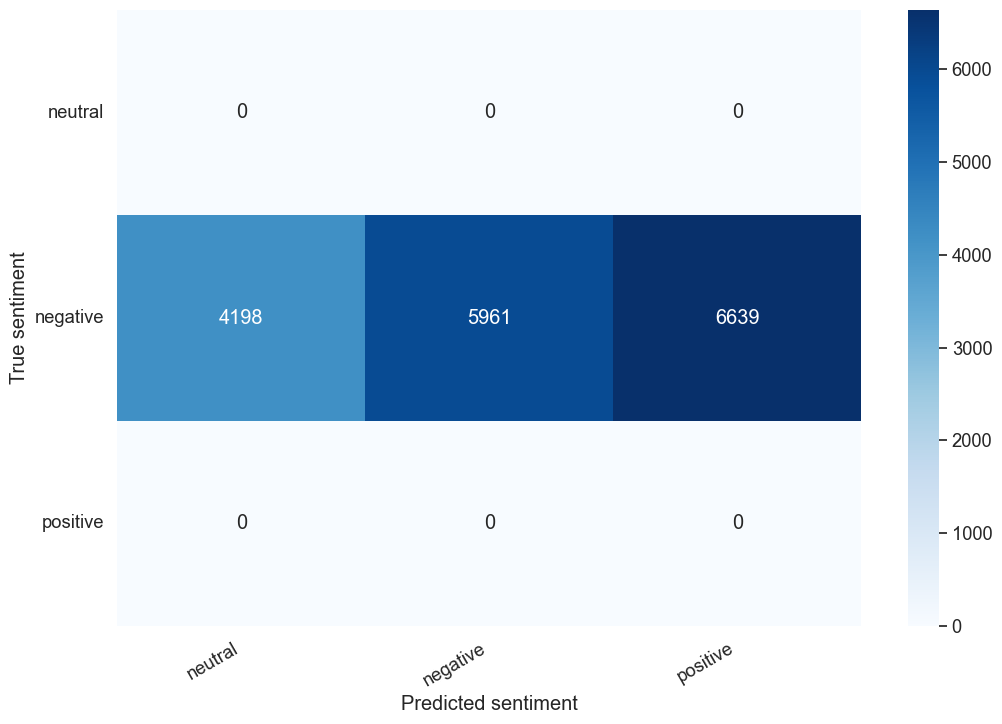

In [9]:
df_ood = pd.read_csv(file_path + '/data/Astock_data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(Astock.string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = Astock.mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = Astock.get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
Astock.show_confusion_matrix(df_ood_cm)

In [10]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBERT_ood.csv',sep='\t')

In [ ]:
# attentions.shape

In [ ]:
# !pip install lit-nlp

In [ ]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [ ]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# mm = models["sst"]

In [ ]:
# mm.model.config

In [ ]:
# widget.render()

In [ ]:
# dataset.LABELS


In [ ]:
# df.loc[df.NAME=="三角防务"]